VARMAX MODEL with London Bikes Data
Inspired from https://mxbu.github.io/logbook/2017/01/04/forecasting-swiss-gdp-growth-with-statsmodels/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar 
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
bikes = pd.read_csv('london_merged.csv')
bikes.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
bike_count=bikes[['cnt']]

In [4]:
#convert the timestamp column from object to Date format
bikes['timestamp'] = pd.to_datetime(bikes['timestamp'])
bikes.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
bike_data = bikes.drop(['timestamp'], axis=1)
bike_data.index = bikes.timestamp
bike_data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


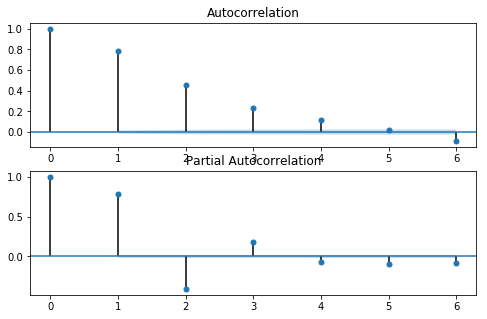

In [7]:
#Plot the PACF AND ACF autocorrelation graphs
fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(bike_count, lags=6, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(bike_count, lags=6, ax=ax2)
plt.show(fig1)

In [5]:
#Inspired from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(bike_data, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(bike_data,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(bike_data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(bike_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
cnt    ::  8197.73   > 179.5199  =>   True
t1     ::  3938.67   > 143.6691  =>   True
t2     ::  2416.01   > 111.7797  =>   True
hum    ::  1490.3    > 83.9383   =>   True
wind_speed ::  899.67    > 60.0627   =>   True
weather_code ::  494.11    > 40.1749   =>   True
is_holiday ::  210.88    > 24.2761   =>   True
is_weekend ::  12.84     > 12.3212   =>   True
season ::  1.2       > 4.1296    =>   False


In [6]:
#splitting the data into train set and test set
#forecasting 4 observations
num_obs = 4
bike_train, bike_test = bike_data[0:-num_obs],bike_data[-num_obs:]

#check the size of the split data
print(bike_train.shape)
print(bike_test.shape)

(17410, 9)
(4, 9)


In [7]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
        
#testing the data for stationarity
for name, col in bike_train.iteritems():
    adfuller_test(col,name=col.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cnt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8753
 No. Lags Chosen       = 41
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "t1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9396
 No. Lags Chosen       = 44
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0018. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "t2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [ ]:
aic = pd.DataFrame(np.zeros((5,5), dtype=float))
bic = pd.DataFrame(np.zeros((5,5), dtype=float))

# Iterate over all VARMAX(p,q) models with p,q in [0,]
for p in  range(5):
    for q in  range(5):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.VARMAX(bike_train, order=(p,q), enforce_invertibility=True)
        try:
            res = mod.fit(maxiter=100, disp = False)
            aic.iloc[p,q] = res.aic
            bic.iloc[p,q] = res.bic
        except:
            aic.iloc[p,q] = np.nan
            bic.iloc[p,q] = np.nan

aic.iloc[0,0] = np.nan
bic.iloc[0,0] = np.nan

print(aic)
print(bic)

q = aic.min().idxmin()
p = aic.idxmin()[q]

In [9]:
# Statespace
mod = sm.tsa.VARMAX(bike_data, order=(4,4), enforce_invertibility=True)
res = mod.fit(maxiter=5000, disp = False)
fig4 = res.plot_diagnostics(0)
print(res.summary())
plt.show(fig4)

KeyboardInterrupt: 

                                                                 Statespace Model Results                                                                 
Dep. Variable:     ['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']   No. Observations:                17410
Model:                                                                                                     VAR(4)   Log Likelihood             -204979.897
                                                                                                      + intercept   AIC                         410715.794
Date:                                                                                            Mon, 16 Dec 2019   BIC                         413650.888
Time:                                                                                                    20:37:37   HQIC                        411682.554
Sample:                                                               

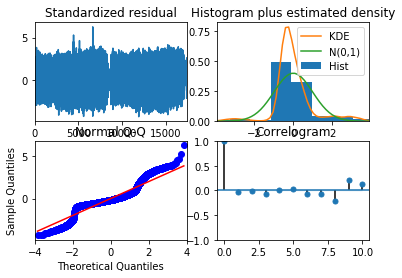

In [7]:
from statsmodels.tsa.statespace.varmax import VARMAX
mod = VARMAX(bike_train, order=(4,0))
res = mod.fit(maxiter=5000, disp = False)
fig4 = res.plot_diagnostics(0)
print(res.summary())
plt.show(fig4)